In [1]:
import os
import scvi
import torch
import anndata
import pynndescent
import numba
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.cm as cm
import scvelo as scv

/hpc/pmc_rios/2.personal/rariese/miniconda/envs/scanpy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
torch.set_float32_matmul_precision('high')

In [ ]:
ref_adata_path='/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/braun_2024_fetal_brain_filtered.h5ad'
adata_path="/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/BRO_RA1_exp023_annotated.h5ad"

In [ ]:
adata = sc.read_h5ad(adata_path)

#### load braun reference data with all genes

In [6]:
ref_adata = sc.read_h5ad(ref_adata_path)
ref_adata

AnnData object with n_obs × n_vars = 1653974 × 33538
    obs: 'Age', 'CellClass', 'Region', 'Subdivision', 'Subregion', 'Tissue', 'TopLevelCluster', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'sample_id', 'cluster_id', 'region_class', 'subregion_class', 'n_genes'
    var: 'Chromosome', 'End', 'Gene', 'Start', 'Strand'
    uns: 'batch_condition', 'schema_version', 'title'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [7]:
print(ref_adata.obs['CellClass'].value_counts())

CellClass
b'Neuron'          558759
b'Radial glia'     518030
b'Neuroblast'      284218
b'Glioblast'       131684
b'Neuronal IPC'    109809
b'Fibroblast'       19080
b'Vascular'         11741
b'Immune'            8101
b'Oligo'             6175
b'Erythrocyte'       4636
b'Placodes'           873
b'Neural crest'       868
Name: count, dtype: int64


In [8]:
harm_ref_adata = ref_adata[:,np.intersect1d(ref_adata.var_names, adata.var_names)].copy()

In [10]:
ref_adata_glia = harm_ref_adata[harm_ref_adata.obs['CellClass'].isin(["b'Glioblast'","b'Oligo'"])].copy()
ref_adata_glia

AnnData object with n_obs × n_vars = 137859 × 22450
    obs: 'Age', 'CellClass', 'Region', 'Subdivision', 'Subregion', 'Tissue', 'TopLevelCluster', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'sample_id', 'cluster_id', 'region_class', 'subregion_class', 'n_genes'
    var: 'Chromosome', 'End', 'Gene', 'Start', 'Strand'
    uns: 'batch_condition', 'schema_version', 'title'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [11]:
ref_adata_glia.layers['counts'] = ref_adata_glia.X.copy()
sc.pp.normalize_total(ref_adata_glia, target_sum=10e4)
sc.pp.log1p(ref_adata_glia)

In [12]:
sc.pp.highly_variable_genes(ref_adata_glia, n_top_genes=3000, batch_key='donor_id', subset=True)

In [13]:
sc.pp.pca(ref_adata_glia)
sc.pp.neighbors(ref_adata_glia)
sc.tl.umap(ref_adata_glia)
sc.tl.leiden(ref_adata_glia)

2024-08-27 12:23:59.587990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 12:24:01.207583: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 12:24:01.658778: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 12:24:28.000198: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


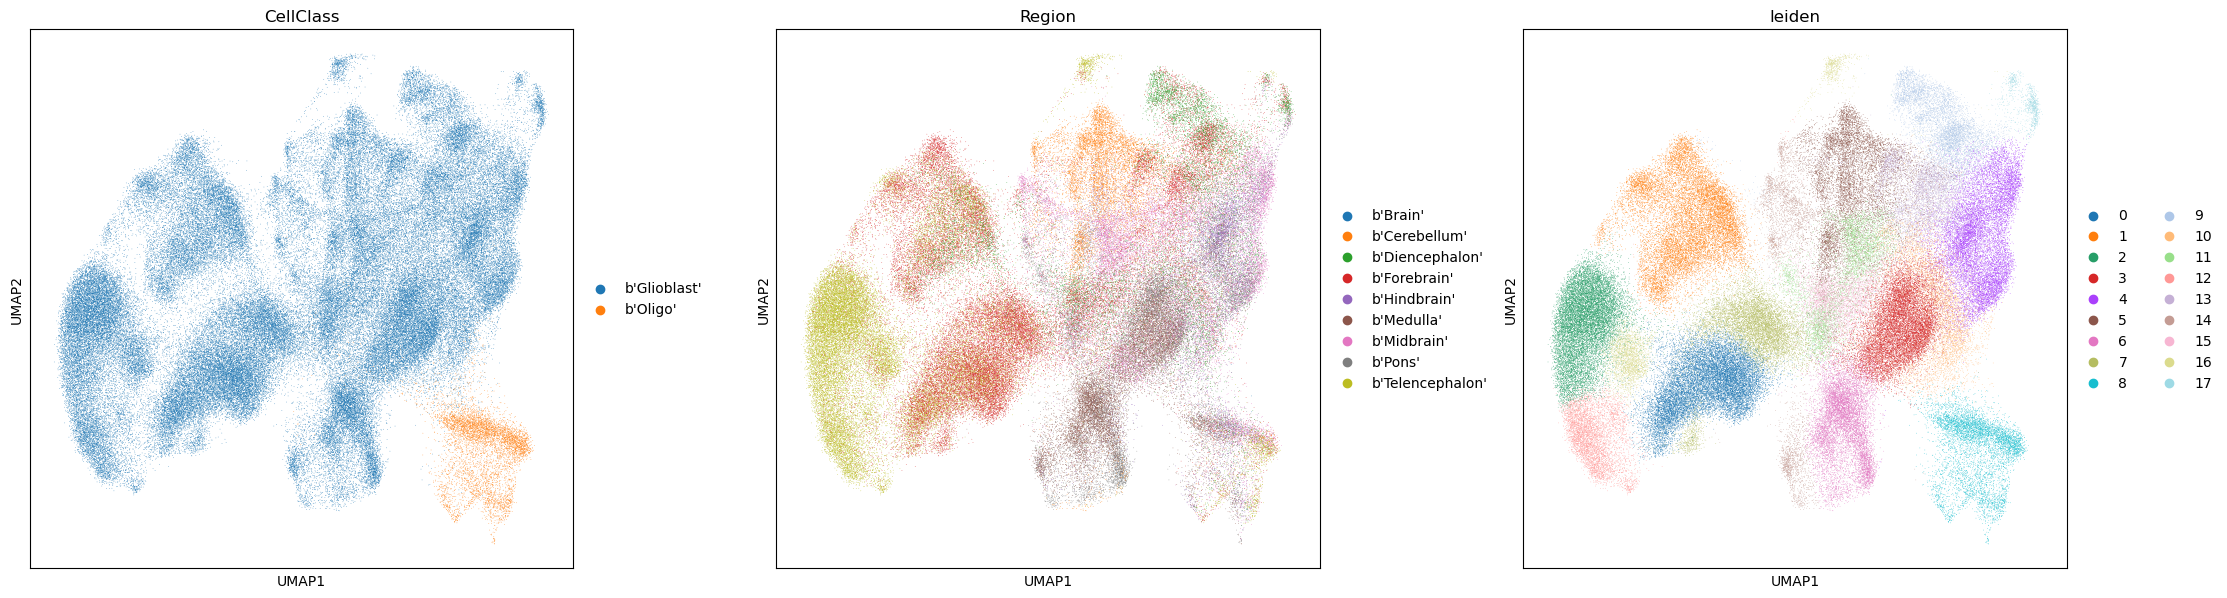

In [14]:
plt.rcParams['figure.figsize']=(7,7)
sc.pl.umap(ref_adata_glia, color=["CellClass","Region","leiden"], wspace=0.25)

# Create SCVI/SCANVI model for the glial compartment

In [15]:
ref_adata_glia.X = ref_adata_glia.layers['counts'].copy()

In [16]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

scvi.settings.seed = 0

# PARAMS
BATCH_SIZE = 1024
EPOCHS_PRETRAIN = 500
EPOCHS_FINETUNE = 100

[rank: 0] Global seed set to 0


In [17]:
ref_adata_glia.varm = dict()
ref_adata_glia.obs["batch"] = ref_adata.obs["donor_id"].astype(str).copy()

In [18]:
scvi.model.SCVI.setup_anndata(
    ref_adata_glia,
    batch_key="batch",
    )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [19]:
vae = scvi.model.SCVI(
    ref_adata_glia,  
    n_latent=20,
    n_hidden=256,
    **arches_params,
    )

In [20]:
vae.train(
    batch_size=BATCH_SIZE,
    max_epochs=EPOCHS_PRETRAIN,
    early_stopping=True,
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-813e9040-38b5-0f9d-9d39-1010f827161f/3/0]


Epoch 500/500: 100%|██████████| 500/500 [45:54<00:00,  4.64s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.15e+3]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [45:54<00:00,  5.51s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.15e+3]


In [21]:
vae.save(
    os.path.join('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/models/scvi_glia_region', "model.pt"),
    overwrite=True,
    save_anndata=False,
)

In [22]:
ref_adata_glia.obs['Region'] = ref_adata_glia.obs['Region'].astype(str)
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=ref_adata_glia,
    labels_key='Region',
    unlabeled_category="Unknown",
)

In [23]:
lvae.train(
    batch_size=BATCH_SIZE,
    max_epochs=EPOCHS_FINETUNE,
    n_samples_per_label=100,
    early_stopping=True,
)

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-813e9040-38b5-0f9d-9d39-1010f827161f/3/0]


Epoch 100/100: 100%|██████████| 100/100 [13:20<00:00,  8.13s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.13e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [13:20<00:00,  8.00s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.13e+3]


In [24]:
lvae.save(
    os.path.join('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/models/scanvi_glia_region', "model.pt"),
    overwrite=True,
    save_anndata=True,
)

In [23]:
lvae.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.5.

Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'Region',
│   'unlabeled_category': 'Unknown',
│   'layer': None,
│   'batch_key': 'batch',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   26   │
│         n_cells          │ 137859 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   10   │
│          n_vars          │  3000  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │ b'BRC2006'  │          0          │
│                    │ b'BRC2021'  │          1          │
│                    │ b'BRC2057'  │          2          │
│                    │ b'BRC2061'  │          3          │
│                    │ b'BRC2073'  │          4          │
│                    │ b'BRC2106A' │          5          │
│                    │ b'BRC2110'  │          6          │
│                    │ b'BRC2114'  │          7          │
│                    │ b'BRC2147'  │          8          │
│                    │ b'BRC2191'  │          9          │
│                    │ b'XDD:313'  │         10          │
│                    │ b'XDD:326'  │         11          │
│                    │ b'XDD:334'  │         12          │
│                    │ b'XDD:342'  │         13          │
│                    │ b'XDD:348'  │         14          │
│                    │ b'XDD:351'  │         15          │
│                    │ b'XDD:358'  │         16          │
│                    │ b'XDD:359'  │         17          │
│                    │ b'XDD:385'  │         18          │
│                    │ b'XDD:395'  │         19          │
│                    │ b'XDD:398'  │         20          │
│                    │ b'XDD:400'  │         21          │
│                    │ b'XHU:292'  │         22          │
│                    │ b'XHU:297'  │         23          │
│                    │ b'XHU:305'  │         24          │
│                    │ b'XHU:307'  │         25          │
└────────────────────┴─────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Region'] │     b'Brain'     │          0          │
│                     │  b'Cerebellum'   │          1          │
│                     │ b'Diencephalon'  │          2          │
│                     │   b'Forebrain'   │          3          │
│                     │   b'Hindbrain'   │          4          │
│                     │    b'Medulla'    │          5          │
│                     │   b'Midbrain'    │          6          │
│                     │     b'Pons'      │          7          │
│                     │ b'Telencephalon' │          8          │
│                     │     Unknown      │          9          │
└─────────────────────┴──────────────────┴─────────────────────┘

In [13]:
lvae = scvi.model.SCANVI.load('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/models/scanvi_glia_region/model.pt')

INFO     File                                                                                                      
         /hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/models/scanvi_glia_re
         gion/model.pt/model.pt already downloaded                                                                 


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/hpc/pmc_rios/2.personal/rariese/miniconda/envs/scvi/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [29]:
ref_adata_glia = sc.read_h5ad('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/models/scanvi_glia_region/model.pt/adata.h5ad')

Now we have a trained SCANVI model on our Braun glial subset. Let's load our glial cells into this!


# Load time course data

In [ ]:
adata = sc.read_h5ad(adata_path)

In [5]:
query_adata = adata[adata.obs["hnoca_leiden_level_3"].isin(['Astrocyte','OPC','Glioblast'])].copy()
query_adata

AnnData object with n_obs × n_vars = 1743 × 23409
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'singlets', 'Day', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'leiden_res_1', 'leiden_res_2', 'leiden_res_3', 'leiden_res_4', 'S_score', 'G2M_score', 'phase', 'leiden_diffmap_res_4', 'snapseed_level_1', 'snapseed_level_2', 'snapseed_level_3', 'snapseed_level_4', 'snapseed_level_5', 'leiden_res_0.5', 'hnoca_level_1', 'hnoca_level_1_score', 'hnoca_level_1_logscore', 'hnoca_level_2', 'hnoca_level_2_score', 'hnoca_level_2_logscore', 'hnoca_level_3', 'hnoca_level_3_score', 'hnoca_level_3_logscore', 'hnoca_level_4', 'hnoca_level_4_score', 'hnoca_level_4_logscore', 'hdbca_

In [6]:
query_adata = query_adata[~query_adata.obs['Day'].isin(["011","020"])]

In [7]:
sc.pp.neighbors(query_adata, n_neighbors=30, n_pcs=30)
sc.tl.leiden(query_adata, key_added='leiden_glial')

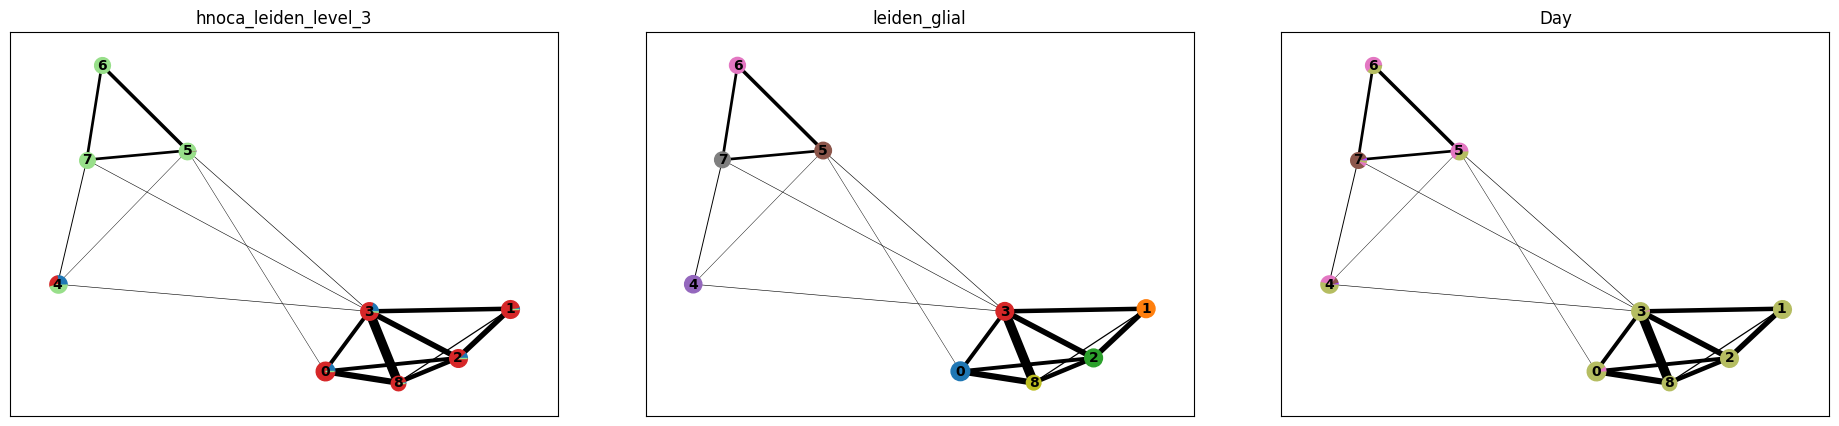

In [8]:
sc.tl.paga(query_adata, groups="leiden_glial")
sc.pl.paga(query_adata, color=["hnoca_leiden_level_3", 'leiden_glial','Day'],threshold=0.03)
sc.tl.umap(query_adata, init_pos='paga')

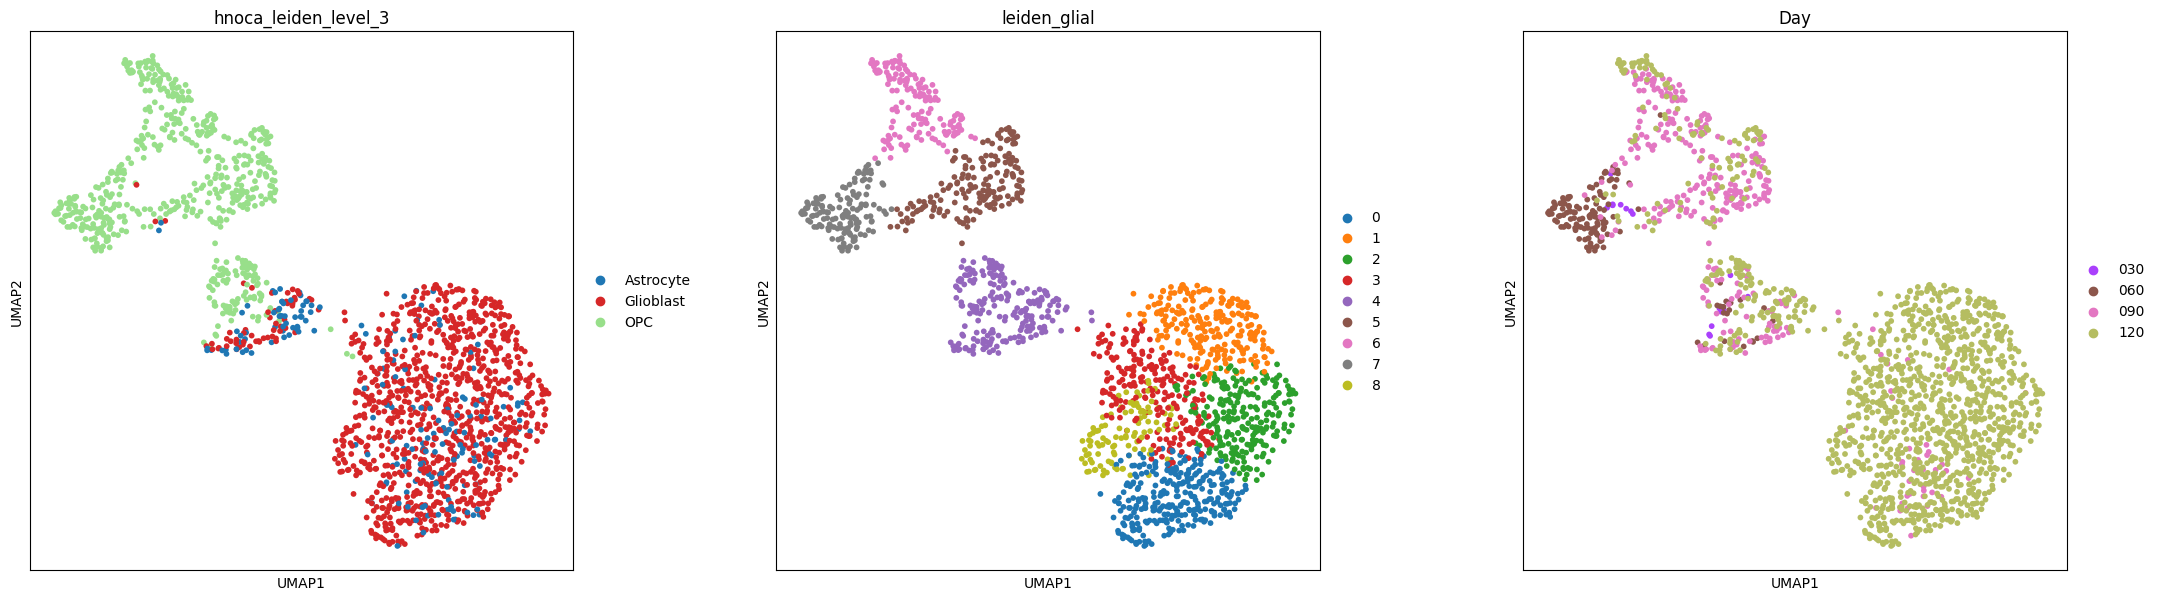

In [9]:
plt.rcParams['figure.figsize']=(7,7)
sc.pl.umap(query_adata, color=["hnoca_leiden_level_3", 'leiden_glial','Day'], wspace=0.25)

## Map glial subset to HDBCA glial cells using SCANVI

In [33]:
query_adata.obs["batch"] = query_adata.obs["Day"].astype('category')

In [34]:
query_adata.obs["CellClass"] = "Unknown"
query_adata.obs["Region"] = "Unknown"
query_adata.obs["Subregion"] = "Unknown"
query_adata.obs["Age"] = "=Unknown"

In [35]:
del query_adata.varm

In [36]:
query_adata.X = query_adata.layers['counts'].copy()

In [37]:
scvi.model.SCANVI.prepare_query_anndata(query_adata, lvae)

INFO     Found 100.0% reference vars in query data.                                                                


In [38]:
vae_q = scvi.model.SCANVI.load_query_data(query_adata, lvae)

In [39]:
query_adata.obs['batch'].value_counts()

batch
120    1261
090     324
060     137
030      19
Name: count, dtype: int64

In [40]:
vae_q.train(
    batch_size=1024,
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-813e9040-38b5-0f9d-9d39-1010f827161f/3/0]
/hpc/pmc_rios/2.personal/rariese/miniconda/envs/scvi/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 100/100: 100%|██████████| 100/100 [00:11<00:00,  9.12it/s, v_num=1, train_loss_step=1.86e+3, train_loss_epoch=1.86e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [00:11<00:00,  9.02it/s, v_num=1, train_loss_step=1.86e+3, train_loss_epoch=1.86e+3]


In [41]:
query_emb = anndata.AnnData(vae_q.get_latent_representation())
query_emb.obs_names = query_adata.obs_names

In [42]:
ref_emb = anndata.AnnData(vae_q.get_latent_representation(ref_adata_glia))

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [43]:
combined_emb = sc.concat(
    (ref_emb, query_emb), index_unique=None, join="outer"
) 

In [44]:
transfers = ["CellClass","Region","Subregion"]

In [45]:
ref_adata_glia.obsm['SCANVI'] = vae_q.get_latent_representation(ref_adata_glia)

In [46]:
X_train = ref_adata_glia.obsm['SCANVI']
ref_nn_index = pynndescent.NNDescent(X_train)
ref_nn_index.prepare()

In [47]:
ref_adata_glia.obs[transfers] = ref_adata_glia.obs[transfers].astype('category')

In [48]:
ref_neighbors, ref_distances = ref_nn_index.query(query_emb.X)

# convert distances to affinities
stds = np.std(ref_distances, axis=1)
stds = (2.0 / stds) ** 2
stds = stds.reshape(-1, 1)
ref_distances_tilda = np.exp(-np.true_divide(ref_distances, stds))
weights = ref_distances_tilda / np.sum(ref_distances_tilda, axis=1, keepdims=True)


@numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty


# for each annotation level, get prediction and uncertainty
label_keys = transfers
for l in label_keys:
    ref_cats = ref_adata_glia.obs[l].cat.codes.to_numpy()[ref_neighbors]
    p, u = weighted_prediction(weights, ref_cats)
    p = np.asarray(ref_adata_glia.obs[l].cat.categories)[p]
    query_emb.obs[l + "_pred"], query_emb.obs[l + "_uncertainty"] = p, u

In [ ]:
uncertainty_threshold = 0.4
for l in label_keys:
    mask = query_emb.obs[l + "_uncertainty"] > uncertainty_threshold
    print(f"{l}: {sum(mask)/len(mask)} unknown")
    query_emb.obs[l + "_pred_unfiltered"] = query_emb.obs[l + "_pred"].copy()
    query_emb.obs[l + "_pred"].loc[mask] = "Unknown"

CellClass: 0.013195639701663799 unknown
Region: 0.2117039586919105 unknown
Subregion: 0.2748135398737808 unknown


In [50]:
## Using cellclass as label_key for scanvi
uncertainty_threshold = 0.4
for l in label_keys:
    mask = query_emb.obs[l + "_uncertainty"] > uncertainty_threshold
    print(f"{l}: {sum(mask)/len(mask)} unknown")
    query_emb.obs[l + "_pred_unfiltered"] = query_emb.obs[l + "_pred"].copy()
    query_emb.obs[l + "_pred"].loc[mask] = "Unknown"

CellClass: 0.0068925904652498565 unknown
Region: 0.29063756461803564 unknown
Subregion: 0.3572659391154509 unknown


In [62]:
for t in transfers:
    print(t)
    query_adata.obs[f'{t}_pred'] = query_emb.obs[f'{t}_pred']
    query_adata.obs[f'{t}_pred_unfiltered'] = query_emb.obs[f'{t}_pred_unfiltered']
    query_adata.obs[f'{t}_uncertainty'] = query_emb.obs[f'{t}_uncertainty']

CellClass
Region
Subregion


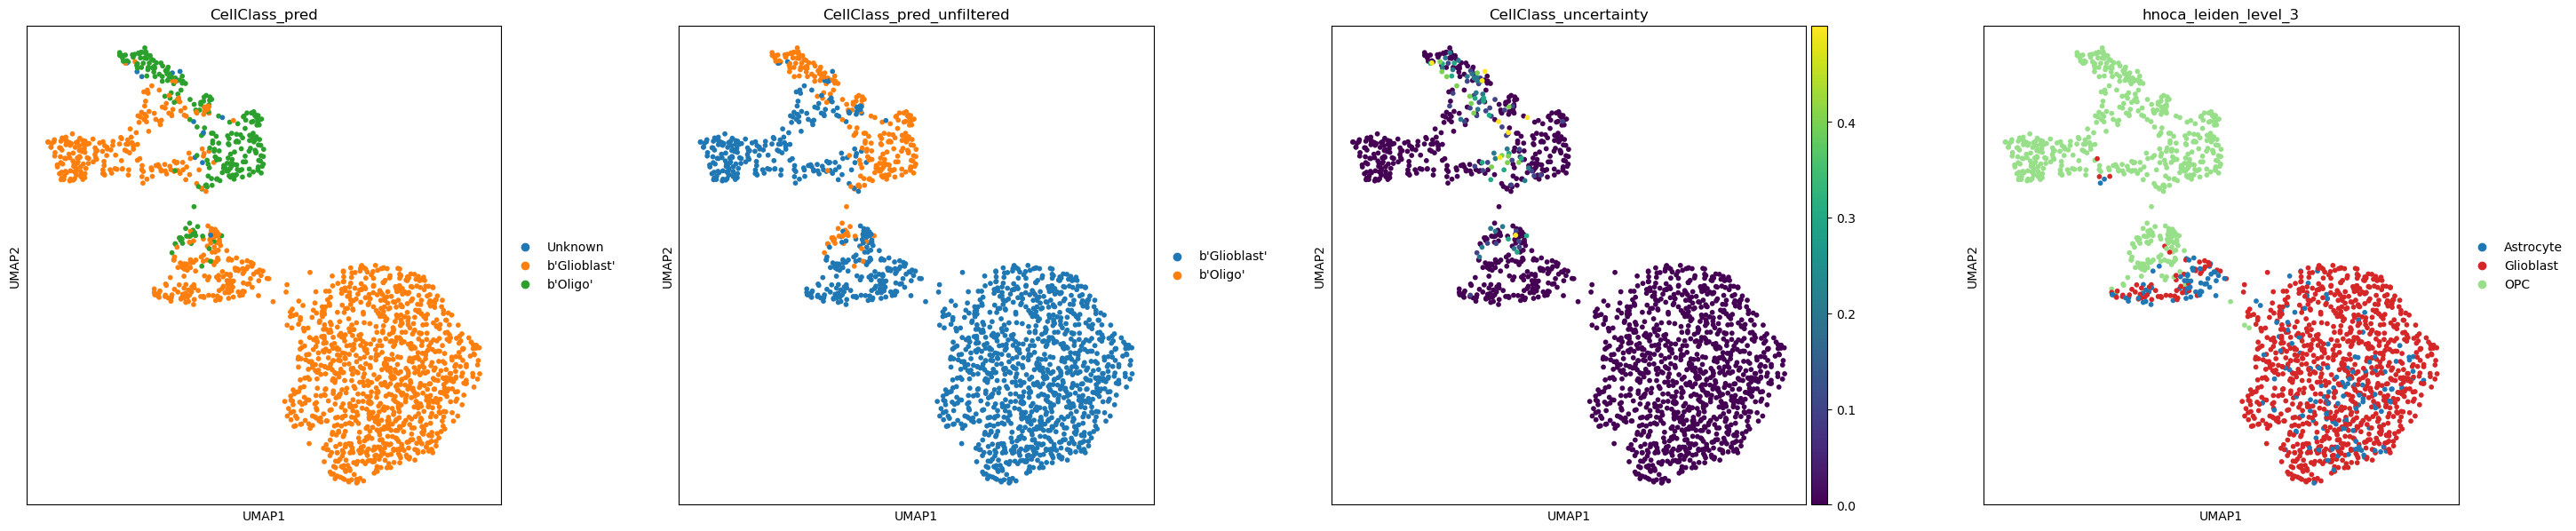

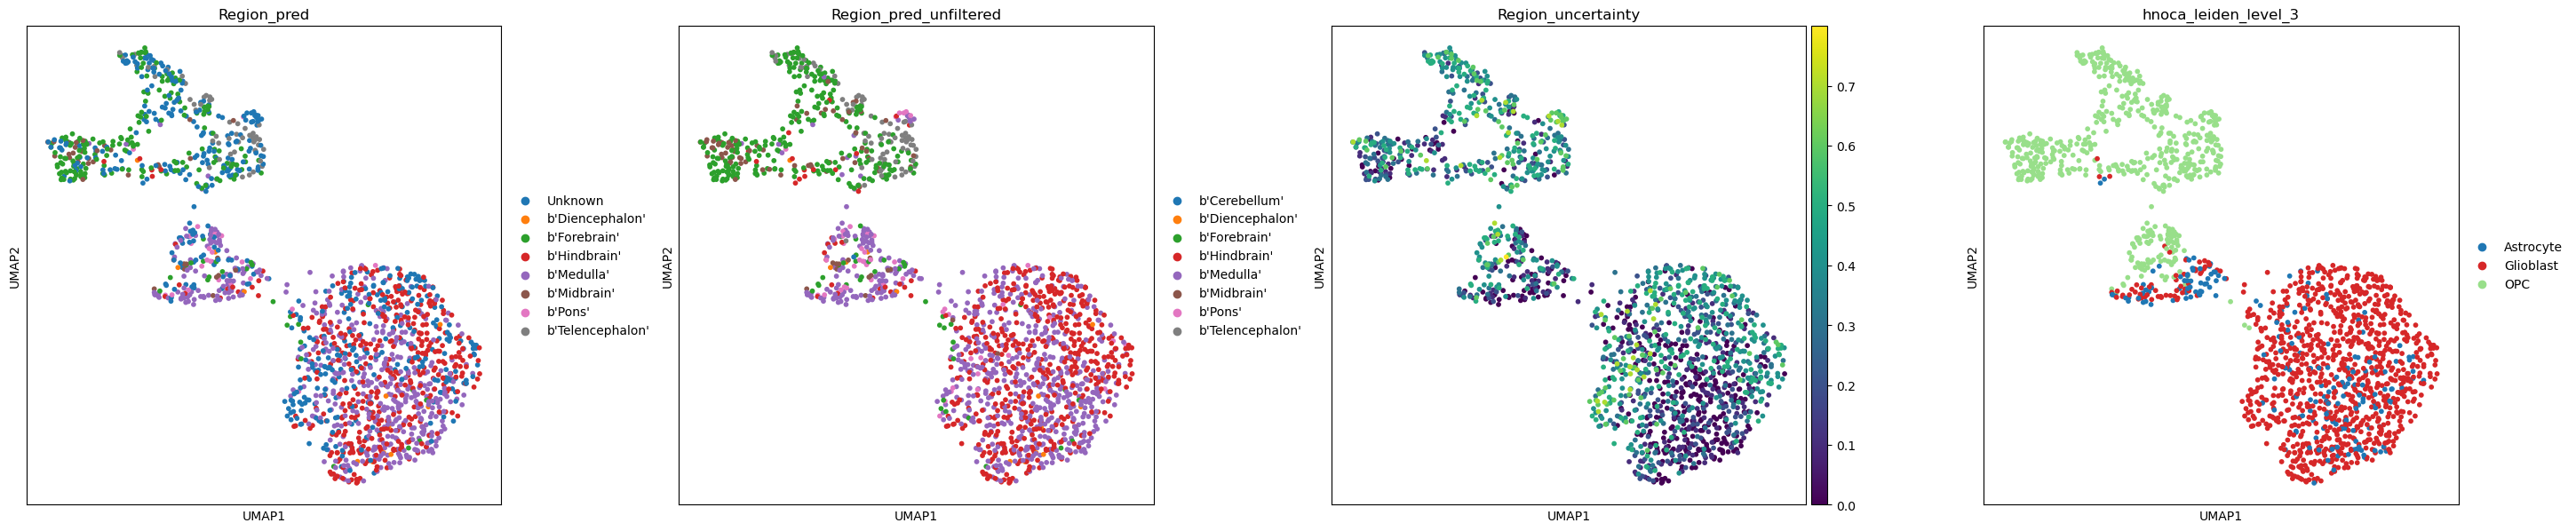

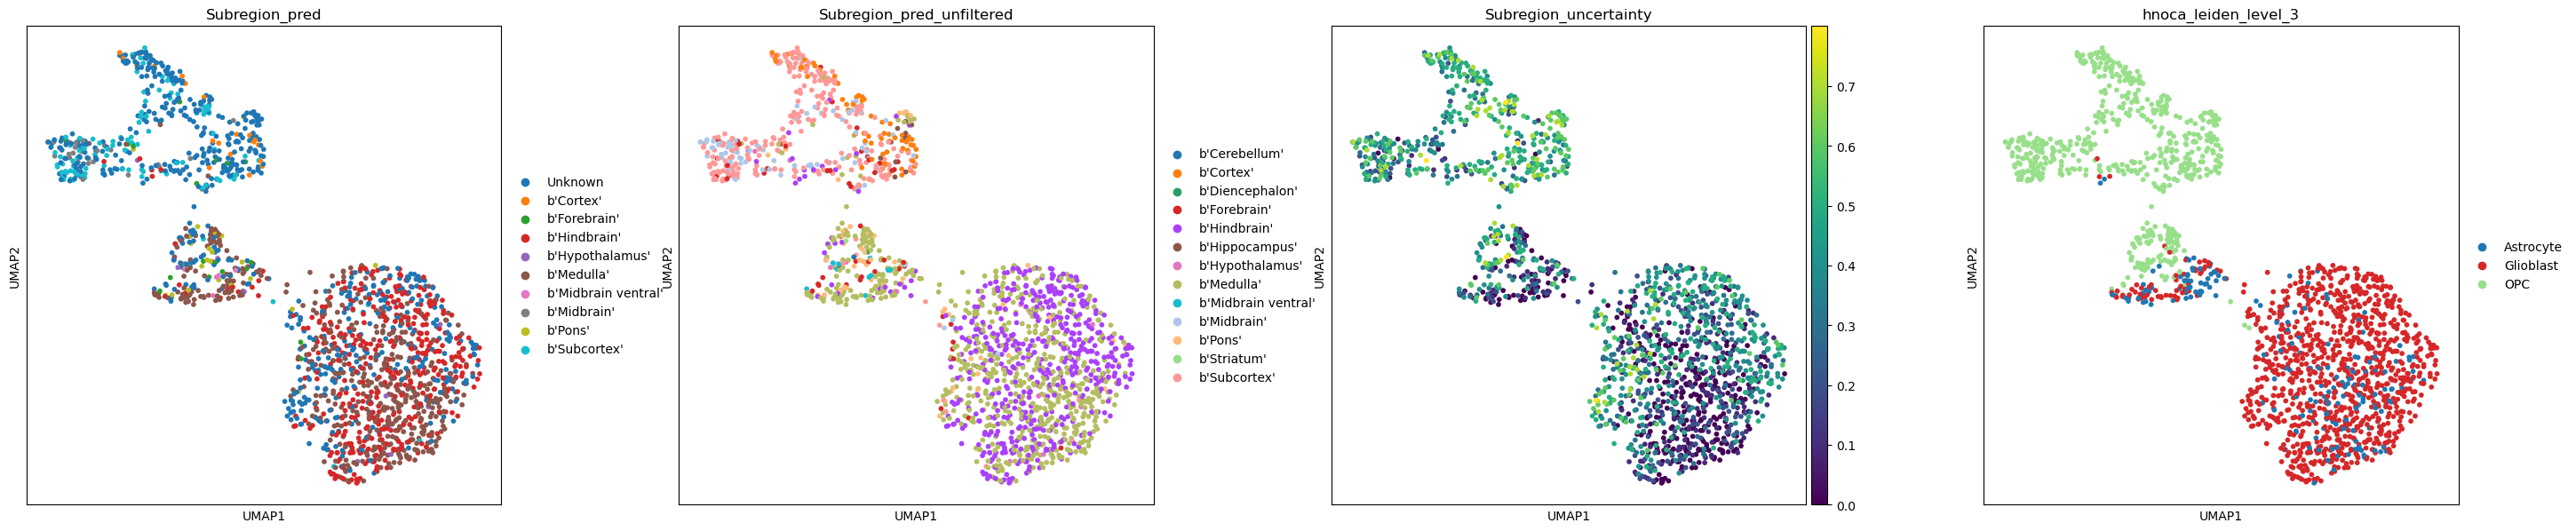

In [63]:
for t in transfers:
    sc.pl.umap(query_adata, color=[f'{t}_pred',f'{t}_pred_unfiltered',f'{t}_uncertainty','hnoca_leiden_level_3'], wspace=0.25)

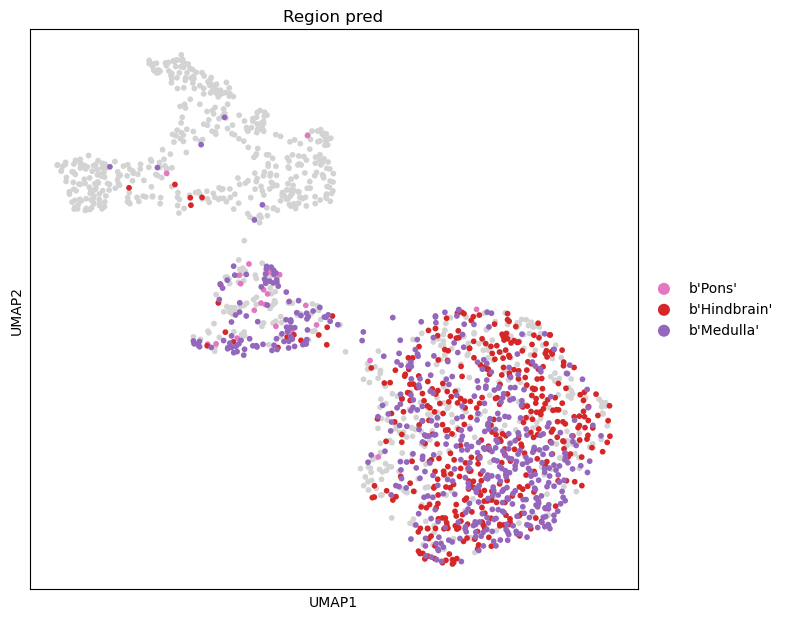

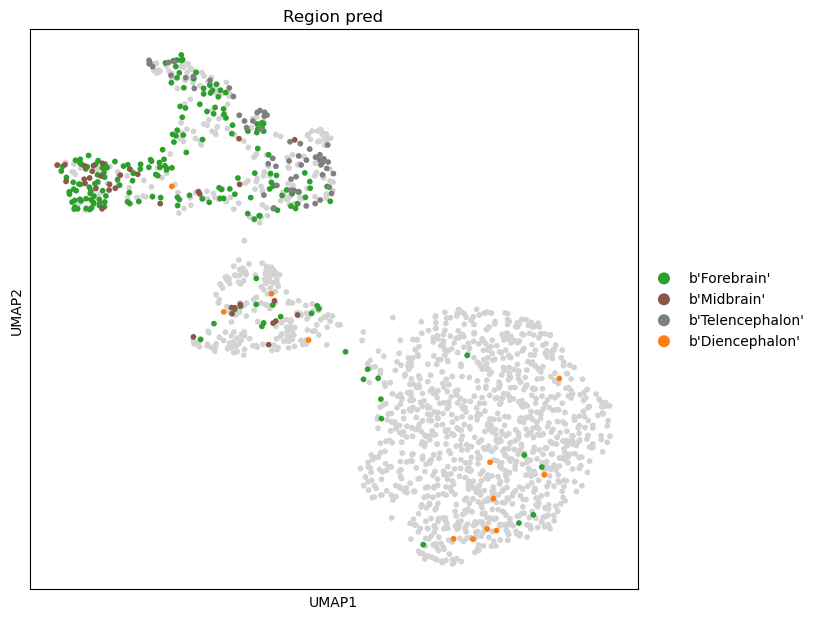

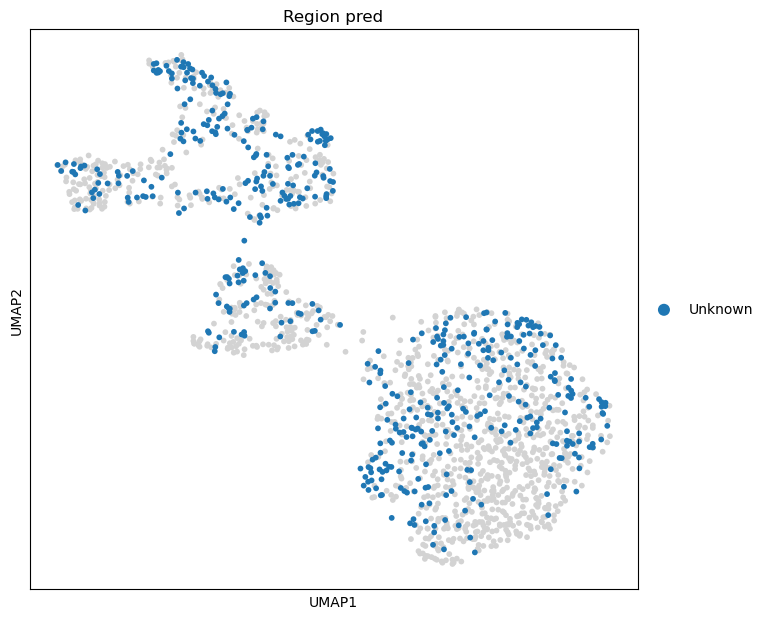

In [64]:
sc.pl.scatter(query_adata, color='Region_pred', basis='umap', groups=["b'Pons'","b'Hindbrain'","b'Medulla'"])
sc.pl.scatter(query_adata, color='Region_pred', basis='umap', groups=["b'Forebrain'","b'Midbrain'","b'Telencephalon'","b'Diencephalon'"])
sc.pl.scatter(query_adata, color='Region_pred', basis='umap', groups=["Unknown"])

In [68]:
region_dict = {
    "b'Forebrain'" : "Forebrain",
    "b'Midbrain'" : "Midbrain",
    "b'Telencephalon'" : "Forebrain",
    "b'Diencephalon'" : "Forebrain",
    "b'Pons'" : "Hindbrain",
    "b'Medulla'" : "Medulla",
    "b'Hindbrain'" : "Hindbrain",
    "Unknown" : "Unknown",
}

query_adata.obs["region_broad"] = query_adata.obs['Region_pred'].map(region_dict).astype("category")

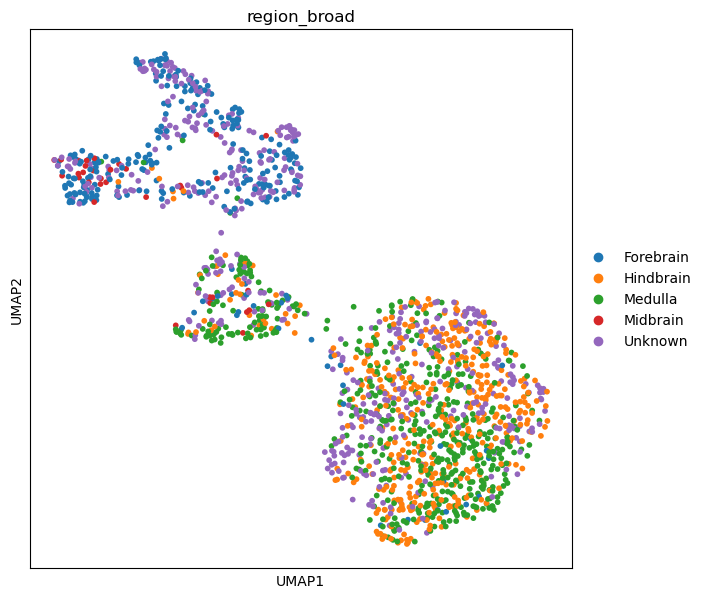

In [69]:
sc.pl.umap(query_adata, color="region_broad")